In [1]:
import os

try:
    has_changed_dir
except:
    has_changed_dir = False

try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

if IN_COLAB:
    %pip install datasets
    %pip install translate-toolkit
    %pip install bitsandbytes

    !git clone https://github.com/MarkusSibbesen/mechinterp_research_project.git

    if not has_changed_dir:
        os.chdir('mechinterp_research_project')
        has_changed_dir = True
else:
    if not has_changed_dir:
        os.chdir('.')
        has_changed_dir = True


Running as a Colab notebook
fatal: destination path 'mechinterp_research_project' already exists and is not an empty directory.


In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.data import random_split, DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer

from collections import defaultdict
import os
import json
from matplotlib import pyplot as plt

from src.dataset_handling import TextClassificationDataset
from src.utils import get_activations_and_labels
from src.sparse_probes import ClassificationProbe

In [3]:
model_url = "EleutherAI/pythia-160m"
model_name = model_url.split('/')[-1]
hookpoint_name = 'gpt_neox.layers.$.mlp.act'

model = AutoModelForCausalLM.from_pretrained(model_url).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_url)

num_hookpoints = model.config.num_hidden_layers
hookpoints = [hookpoint_name.replace('$', str(i)) for i in range(num_hookpoints)]
input_size = model.config.intermediate_size

data_path = 'data/split/tedtalks_test.tsv'
dataset = TextClassificationDataset.from_tsv(data_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [4]:
model_folder = f'models/sparse_probes/{model_name}'

probes = defaultdict(dict)

for name in os.listdir(model_folder):
    for hookpoint in hookpoints:

        with open(f'{model_folder}/{name}/{hookpoint}.json', 'r') as file:
            meta_data = json.load(file)

        probe = ClassificationProbe(input_size, device)
        probe.load_state_dict(torch.load(f'{model_folder}/{name}/{hookpoint}.pt', weights_only=True))

        probes[meta_data['reg_lambda']][hookpoint] = probe

In [5]:
num_sentences = 500
text_batch, label_batch = dataset[:num_sentences]

activations, labels = get_activations_and_labels(text_batch, label_batch, model, hookpoints, tokenizer, device)

In [6]:
accuracy = defaultdict(dict)

for reg_lambda in probes.keys():
    for hookpoint in hookpoints:

        preds = (probes[reg_lambda][hookpoint](activations[hookpoint].to(device)) > 0.5).float()

        acc = (preds == labels).sum() / len(preds)
        accuracy[reg_lambda][hookpoint] = acc.item()

with open(f'figures/sparse_probes/{model_name}.json', 'w') as file:
    json.dump(accuracy, file, indent=4)

<ipython-input-7-26f2f8a5f11d>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(hookpoints, rotation=45, ha='right')


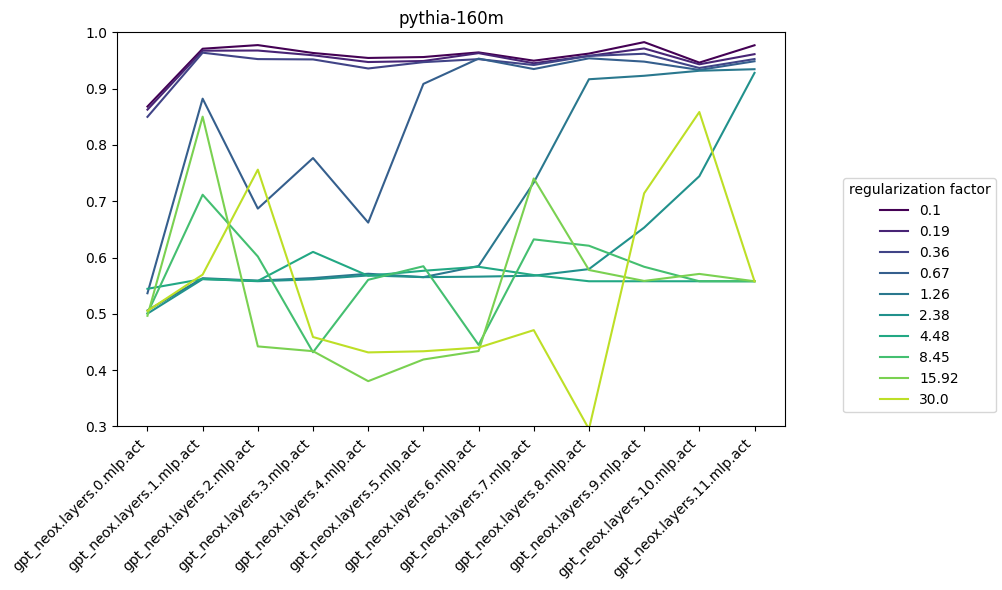

In [7]:
# Specify the number of colors you need
num_colors = len(probes.keys())

# Choose a colormap
cmap = plt.cm.viridis  # You can use any colormap, e.g., 'plasma', 'coolwarm', etc.

# Generate a list of evenly spaced colors
colors = [cmap((i / num_colors)) for i in range(num_colors)]
reg_lambdas = sorted(list(accuracy.keys()), key=lambda x: float(x))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_title(model_name)
ax.set_xticklabels(hookpoints, rotation=45, ha='right')

for reg_lambda, color in zip(reg_lambdas, colors):
    acc = accuracy[reg_lambda]
    ax.plot(acc.keys(), acc.values(), color=color, label=round(float(reg_lambda), 2))

ax.set_ylim(0.30, 1)
fig.legend(loc='right', title='regularization factor')
fig.tight_layout(rect=[0, 0, 0.8, 1])
fig.show()

fig.savefig(f'figures/sparse_probes/{model_name}.png', dpi=300)

In [8]:
!git config --global user.email
!git config --global user.name "Markus Sibbesen"

In [9]:
!git add figures/sparse_probes/*

!git commit -m "probe analysis 160m probe"

[main 11e31b3] probe analysis 160m probe
 2 files changed, 142 insertions(+)
 create mode 100644 figures/sparse_probes/pythia-160m.json
 rewrite figures/sparse_probes/pythia-160m.png (93%)


In [10]:
# insert github auth below --- couldnt figure out how to do it a better way
# REMEMBER TO DELETE AFTERWARDS!!!!!

## -----v------

## -----^------

!git push

Enumerating objects: 10, done.
Counting objects: 100% (10/10), done.
Delta compression using up to 12 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (6/6), 389.81 KiB | 15.59 MiB/s, done.
Total 6 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/MarkusSibbesen/mechinterp_research_project.git
   15e948d..11e31b3  main -> main
